# Datasets Processing for MI

## Data Analysis

In [1]:
import pyedflib
import os
import numpy as np
%matplotlib inline
# get file in current directory
with pyedflib.EdfReader("./MI/S067/S067R05.edf") as f:
    n = f.signals_in_file
    signal_labels = f.getSignalLabels()
    sigbufs = np.zeros((n, f.getNSamples()[0]))
    for i in np.arange(n):
        sigbufs[i, :] = f.readSignal(i)

### Plot 

In [2]:
signal_labels[7:13] # only extract Cx
print(f'len of sigbufs = {len(sigbufs)}, shape is = {np.array(sigbufs).shape}')

len of sigbufs = 64, shape is = (64, 19680)


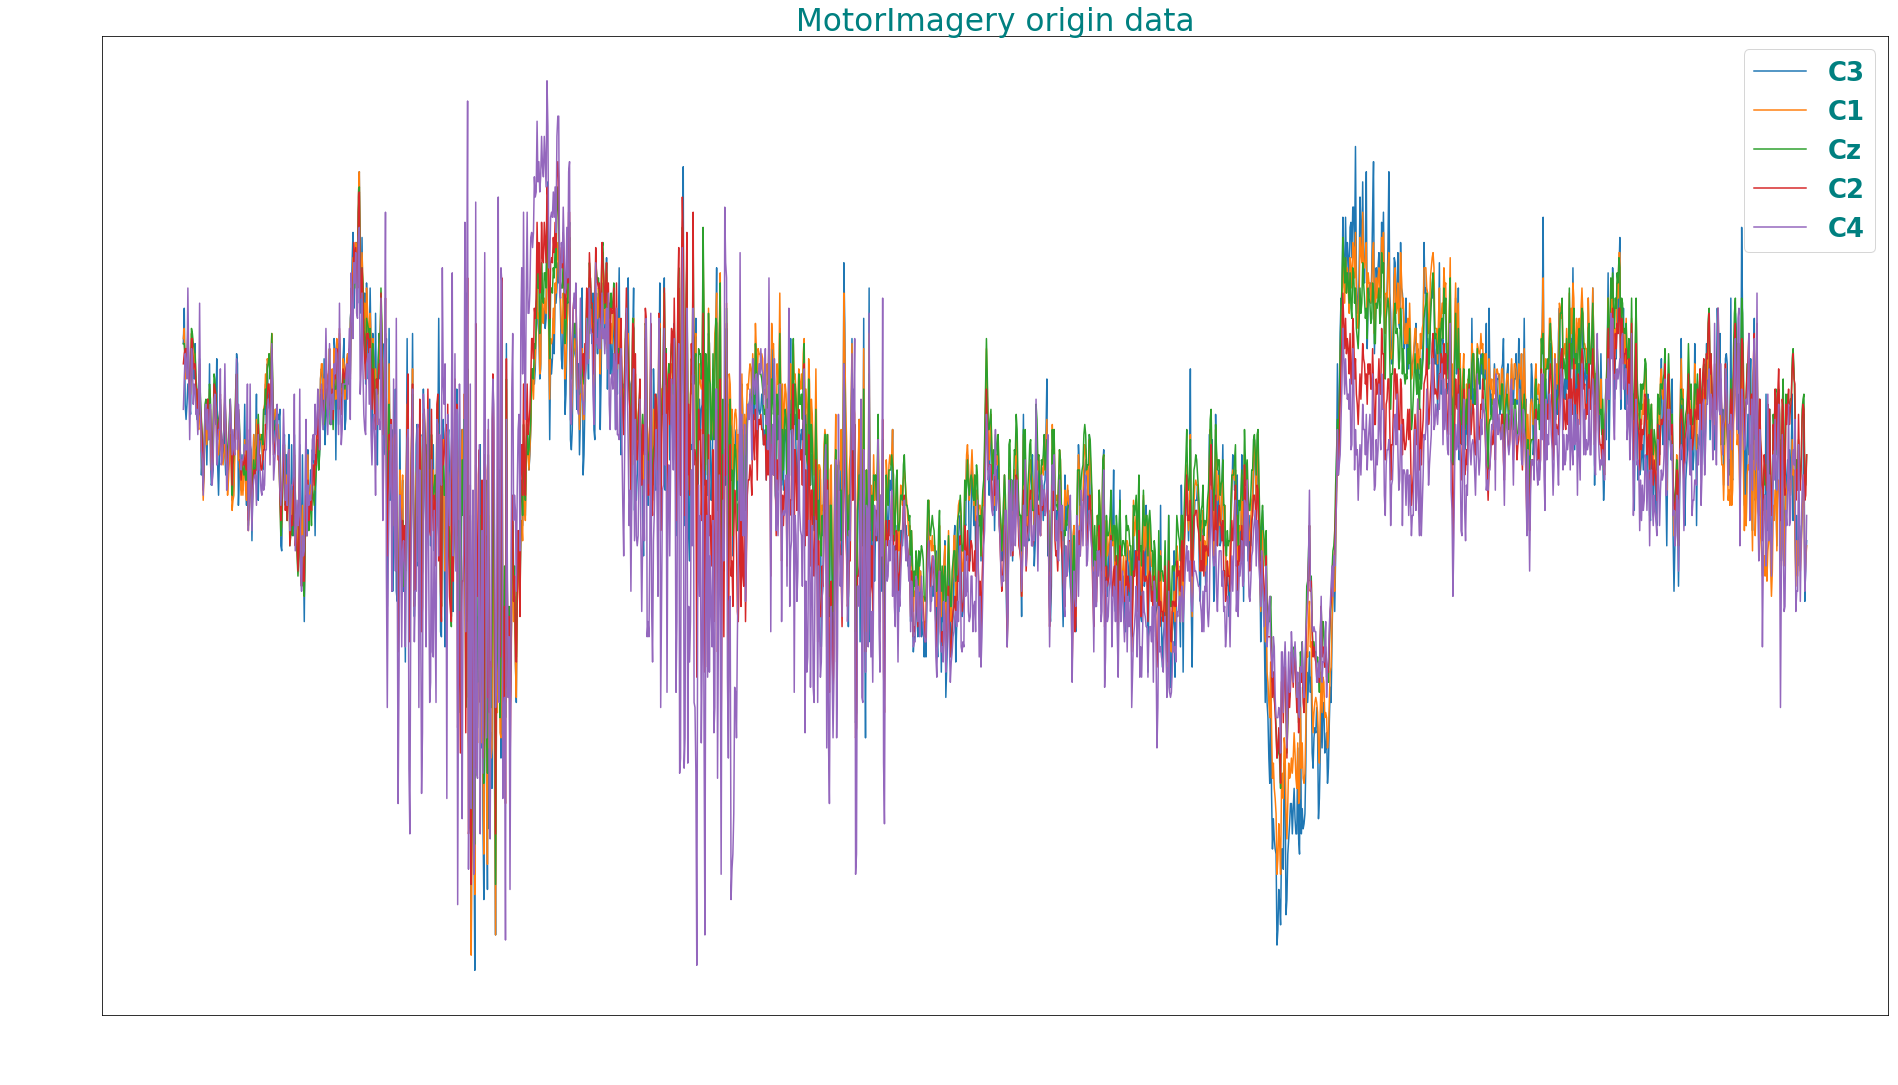

In [4]:
import matplotlib.pyplot as plt
import numpy as np
y = np.array(sigbufs[8:13, :])
y = np.transpose(y)
# Set Matplot Parameter
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 26}
plt.rc('font', **font)
plt.rcParams["figure.figsize"] = [32,18]

plt.rcParams.update({'text.color' : "teal",
                     'axes.labelcolor' : "white",
                     'xtick.color' : "white",
                     'ytick.color' : "white"})

labels = ['C3', 'C1', 'Cz', 'C2', 'C4']
y = y[600:2400]
plt.plot(y)
plt.xlabel('x')
plt.ylabel('Ampltitude')
plt.title(f"MotorImagery origin data")
# 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4'
plt.legend(labels, loc=1)
plt.show()

### Wavelets

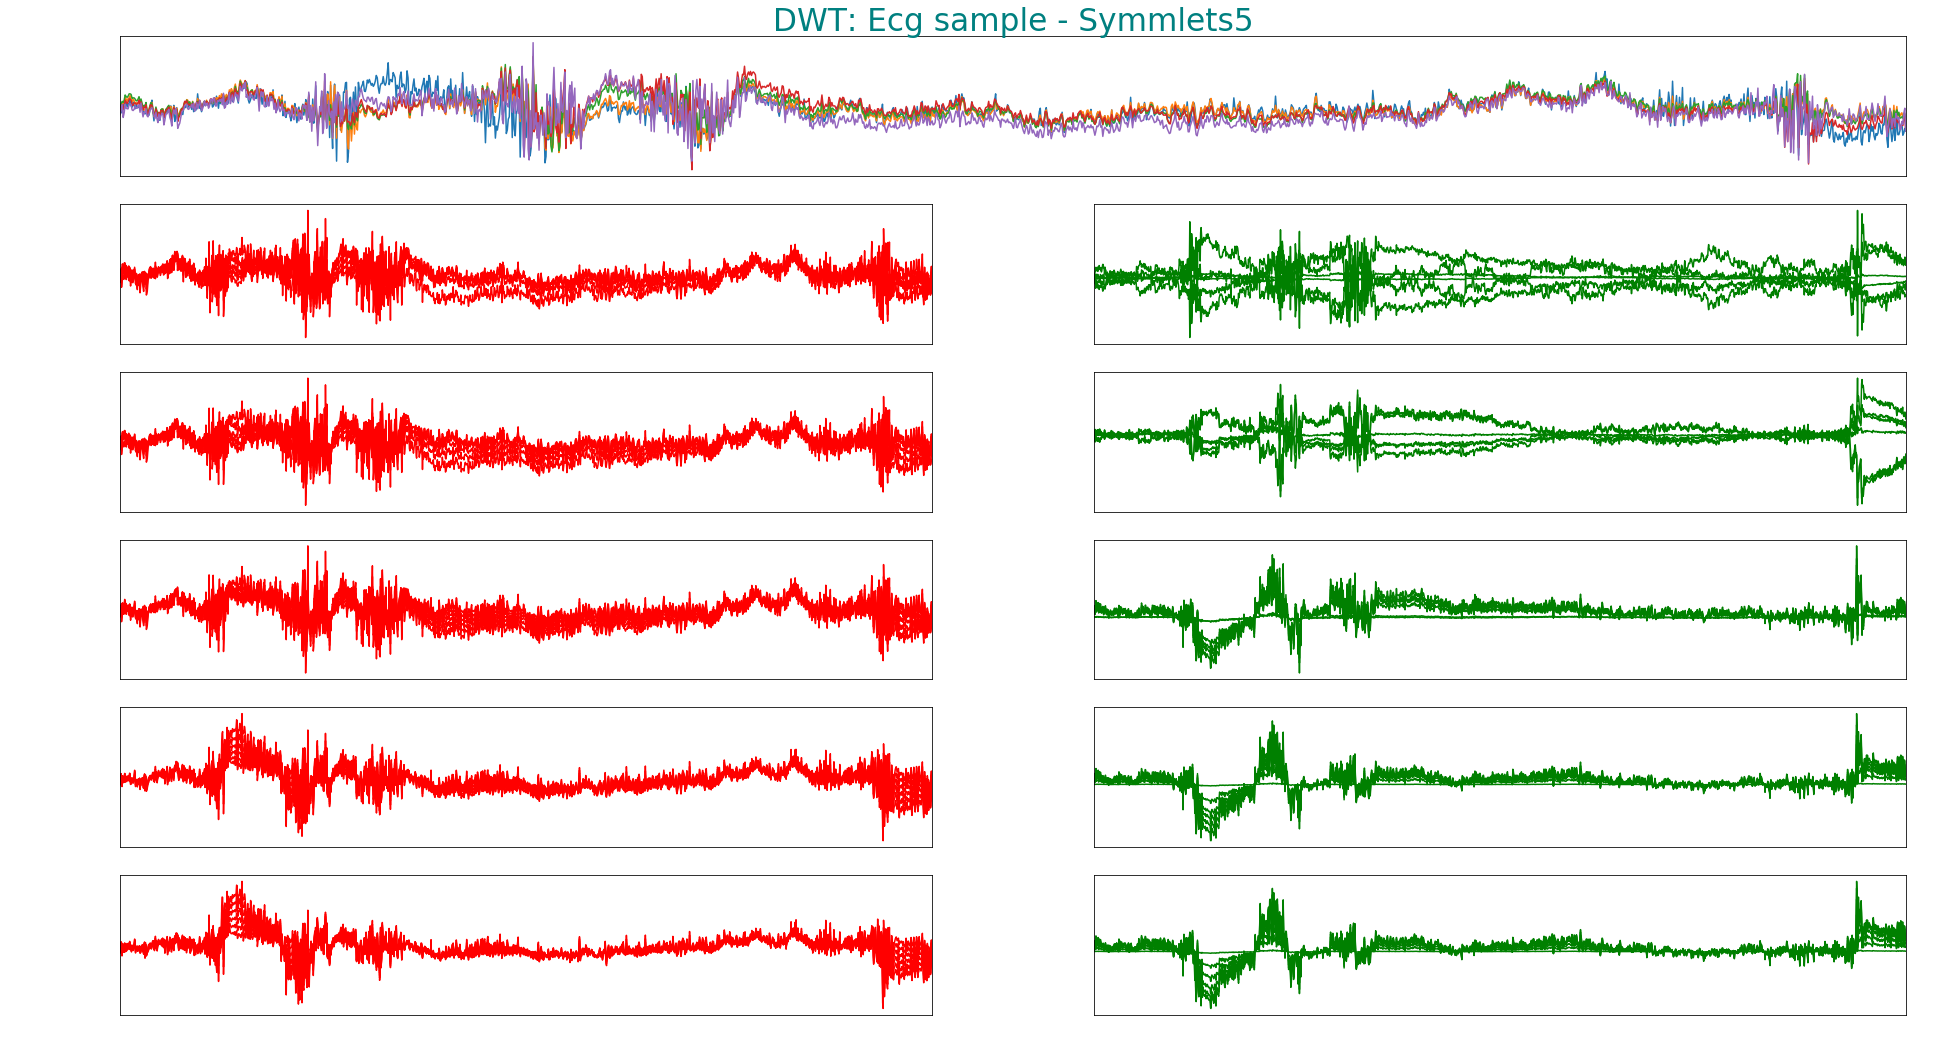

In [4]:
import pywt

mode = pywt.Modes.smooth

def plot_signal_decomp(data, w, title):
    """Decompose and plot a signal S.
    S = An + Dn + Dn-1 + ... + D1
    """
    w = pywt.Wavelet(w)
    a = data
    ca = []
    cd = []
    for i in range(5):
        (a, d) = pywt.dwt(a, w, mode)
        ca.append(a)
        cd.append(d)

    rec_a = []
    rec_d = []

    for i, coeff in enumerate(ca):
        coeff_list = [coeff, None] + [None] * i
        rec_a.append(pywt.waverec(coeff_list, w))

    for i, coeff in enumerate(cd):
        coeff_list = [None, coeff] + [None] * i
        rec_d.append(pywt.waverec(coeff_list, w))
    
    fig = plt.figure()
    ax_main = fig.add_subplot(len(rec_a) + 1, 1, 1)
    ax_main.set_title(title)
    ax_main.plot(data)
    ax_main.set_xlim(0, len(data) - 1)

    for i, y in enumerate(rec_a):
        ax = fig.add_subplot(len(rec_a) + 1, 2, 3 + i * 2)
        ax.plot(y, 'r')
        ax.set_xlim(0, len(y) - 1)
        ax.set_ylabel("A%d" % (i + 1))

    for i, y in enumerate(rec_d):
        ax = fig.add_subplot(len(rec_d) + 1, 2, 4 + i * 2)
        ax.plot(y, 'g')
        ax.set_xlim(0, len(y) - 1)
        ax.set_ylabel("D%d" % (i + 1))
    return rec_a[4]
out = plot_signal_decomp(y, 'db4', "DWT: Ecg sample - Symmlets5")


plt.show()

### FFT

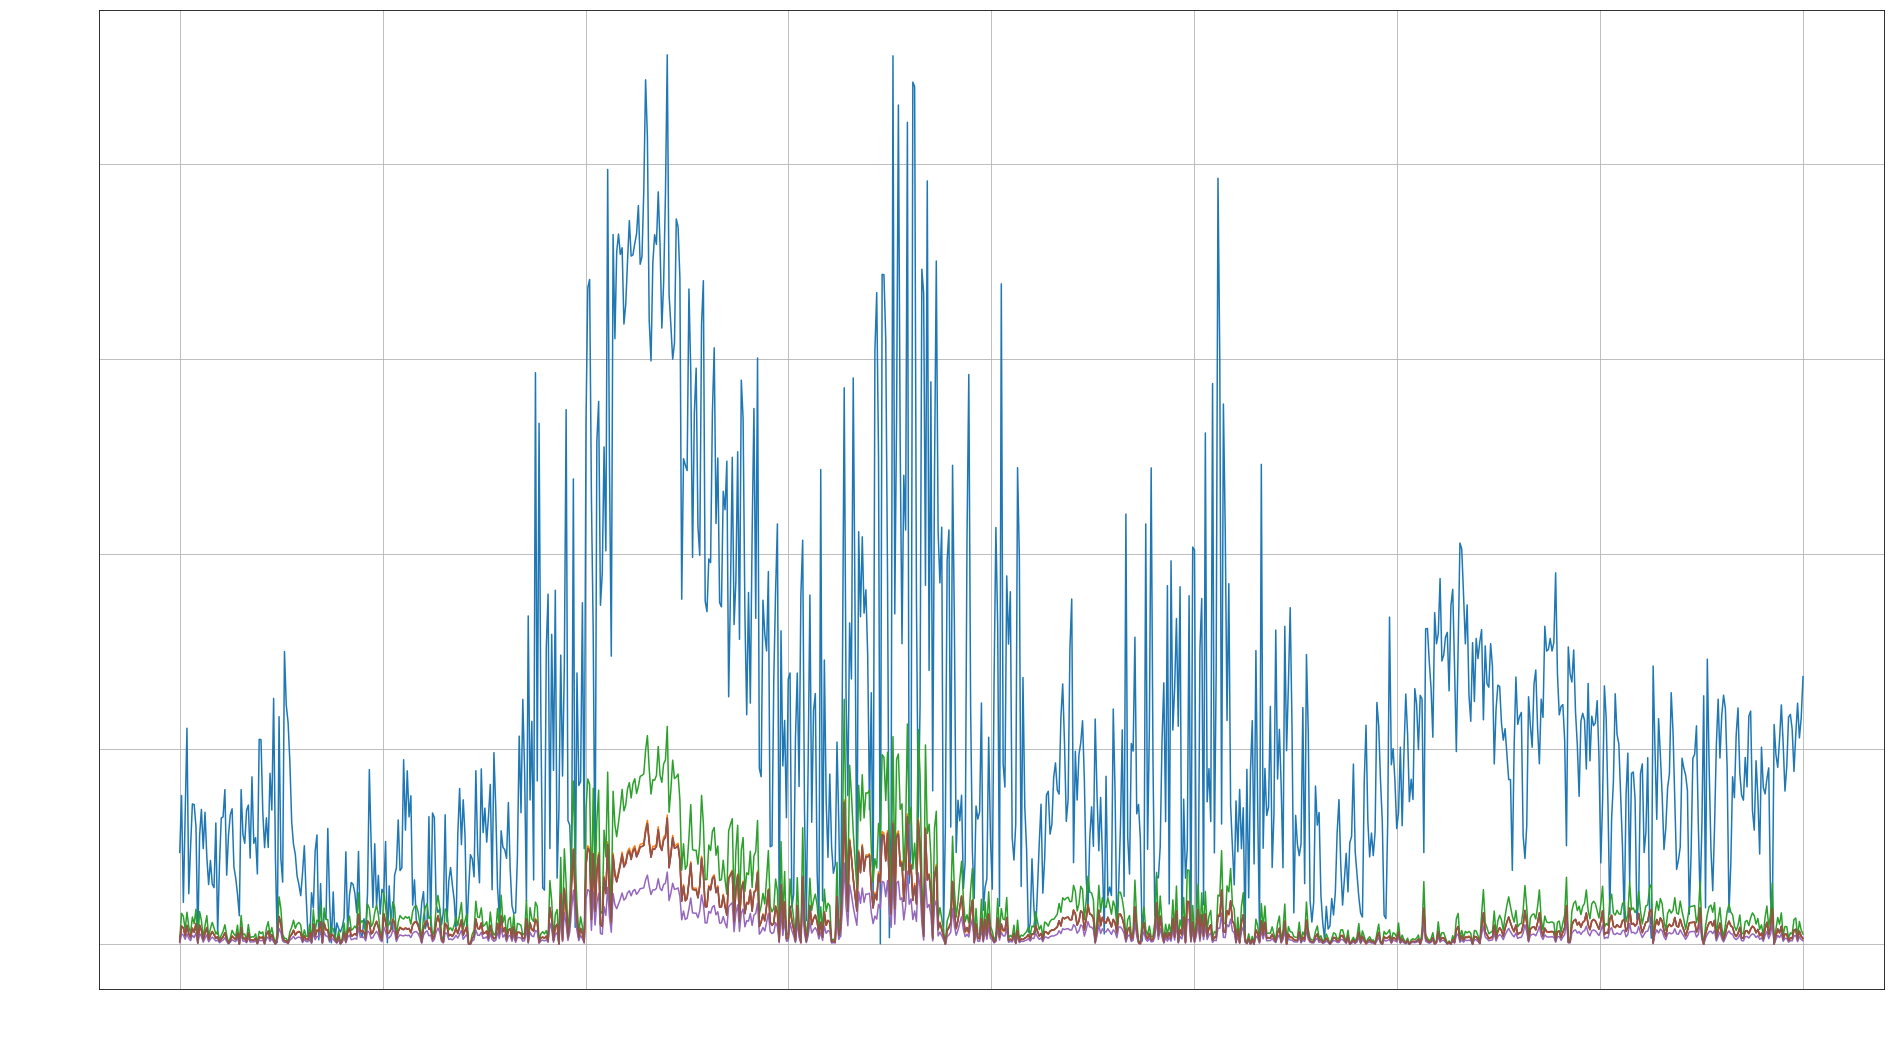

In [5]:
from scipy.fftpack import rfft

f_s = 160 # Sampling Rate
T = 1 / f_s
N = len(y)
x = np.linspace(0, N*T, N)
yf = np.absolute(rfft(out))
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
plt.plot(xf, abs(yf[0:N//2]))
plt.grid()
plt.xlabel('Frequency')
plt.ylabel(r'Spectral Amplitude')
plt.show()

## Wavelet Packets Decomposition

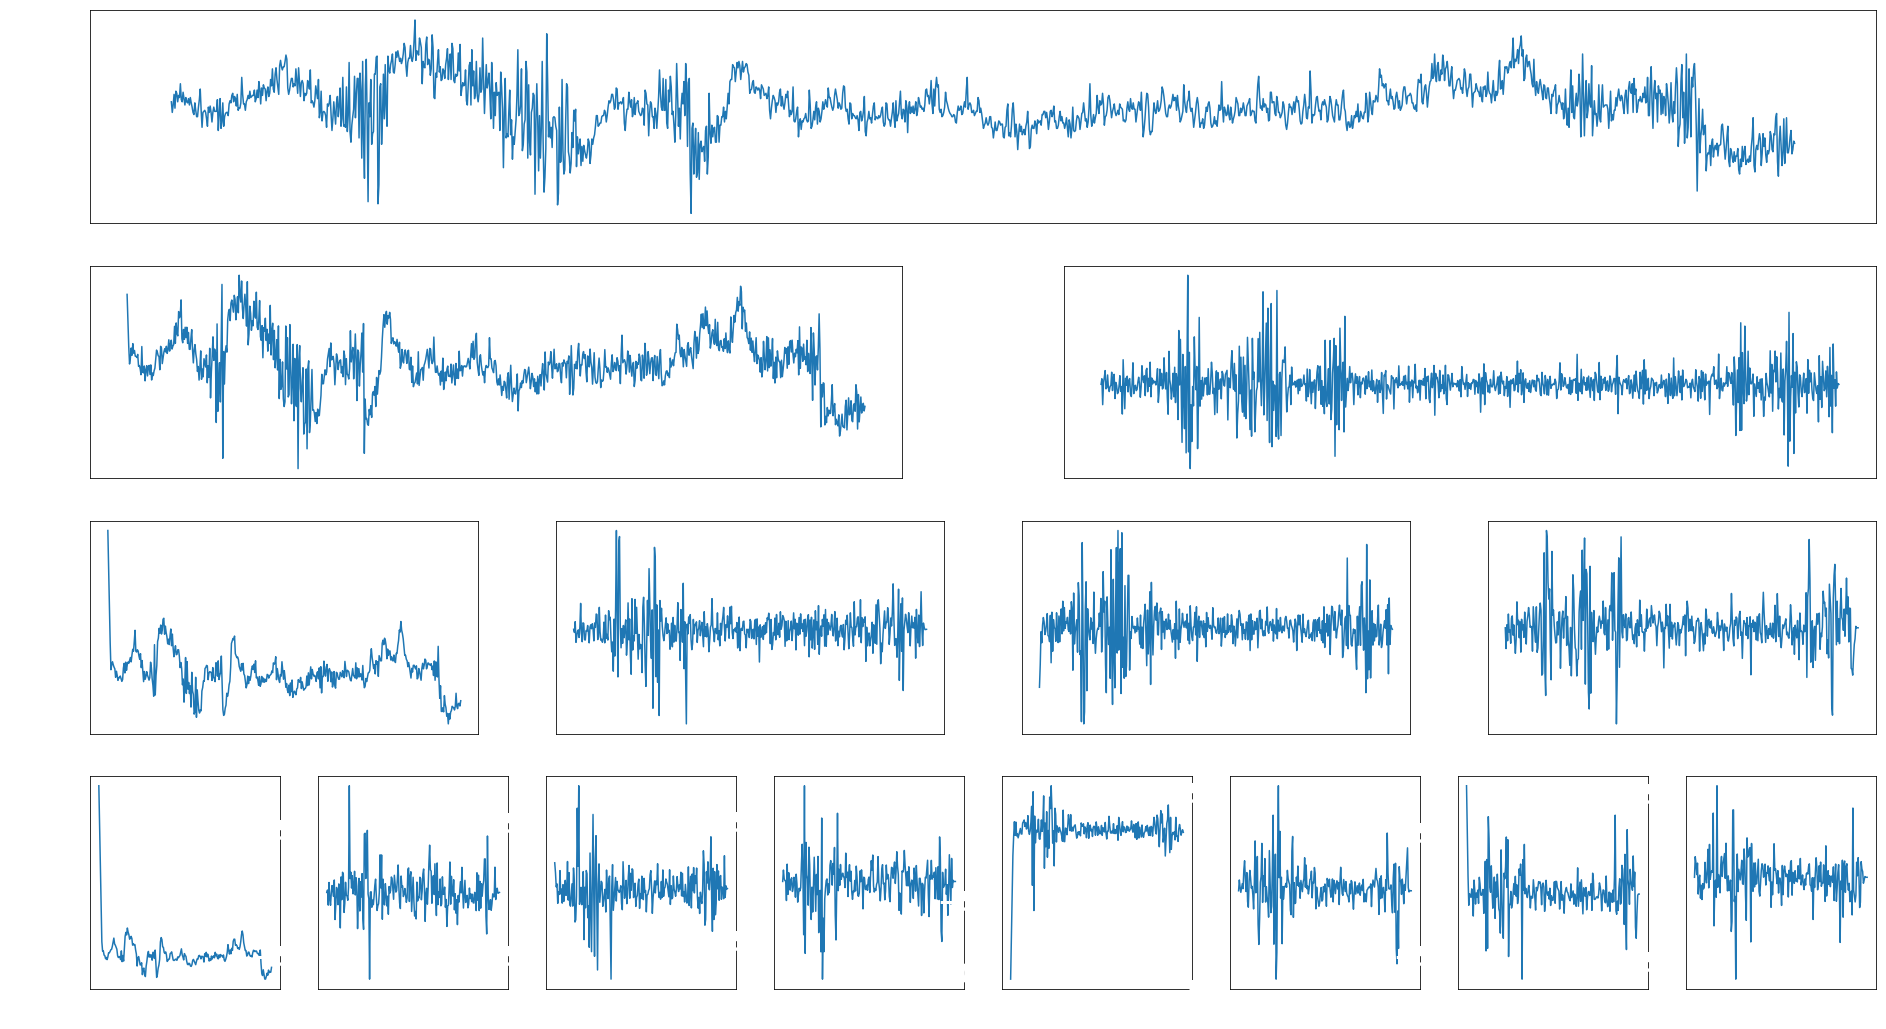

In [6]:
mode = pywt.Modes.smooth

def plot_packets_decomp(data, w, title):
    w = pywt.Wavelet(w)
    a = data
    wp = pywt.WaveletPacket(a, w, mode)
    
    # origin
    plt.subplot(4, 1, 1)
    plt.plot(wp.data)
    
    # level1
    plt.subplot(4, 2, 3)
    plt.plot(wp['a'].data)
    plt.subplot(4, 2, 4)
    plt.plot(wp['d'].data)
    
    # level2
    plt.subplot(4, 4, 9)
    plt.plot(wp['aa'].data)
    plt.subplot(4, 4, 10)
    plt.plot(wp['ad'].data)
    plt.subplot(4, 4, 11)
    plt.plot(wp['da'].data)
    plt.subplot(4, 4, 12)
    plt.plot(wp['dd'].data)
    
    # level3
    plt.subplot(4, 8, 25)
    plt.plot(wp['aaa'].data)
    plt.subplot(4, 8, 26)
    plt.plot(wp['aad'].data)
    plt.subplot(4, 8, 27)
    plt.plot(wp['ada'].data)
    plt.subplot(4, 8, 28)
    plt.plot(wp['add'].data)
    
    plt.subplot(4, 8, 29)
    plt.plot(wp['daa'].data)
    plt.subplot(4, 8, 30)
    plt.plot(wp['dad'].data)
    plt.subplot(4, 8, 31)
    plt.plot(wp['dda'].data)
    plt.subplot(4, 8, 32)
    plt.plot(wp['ddd'].data)
    
    
plot_packets_decomp(y[:,0], 'db4', 'Wavelet Packets' )

<function matplotlib.pyplot.show(*args, **kw)>

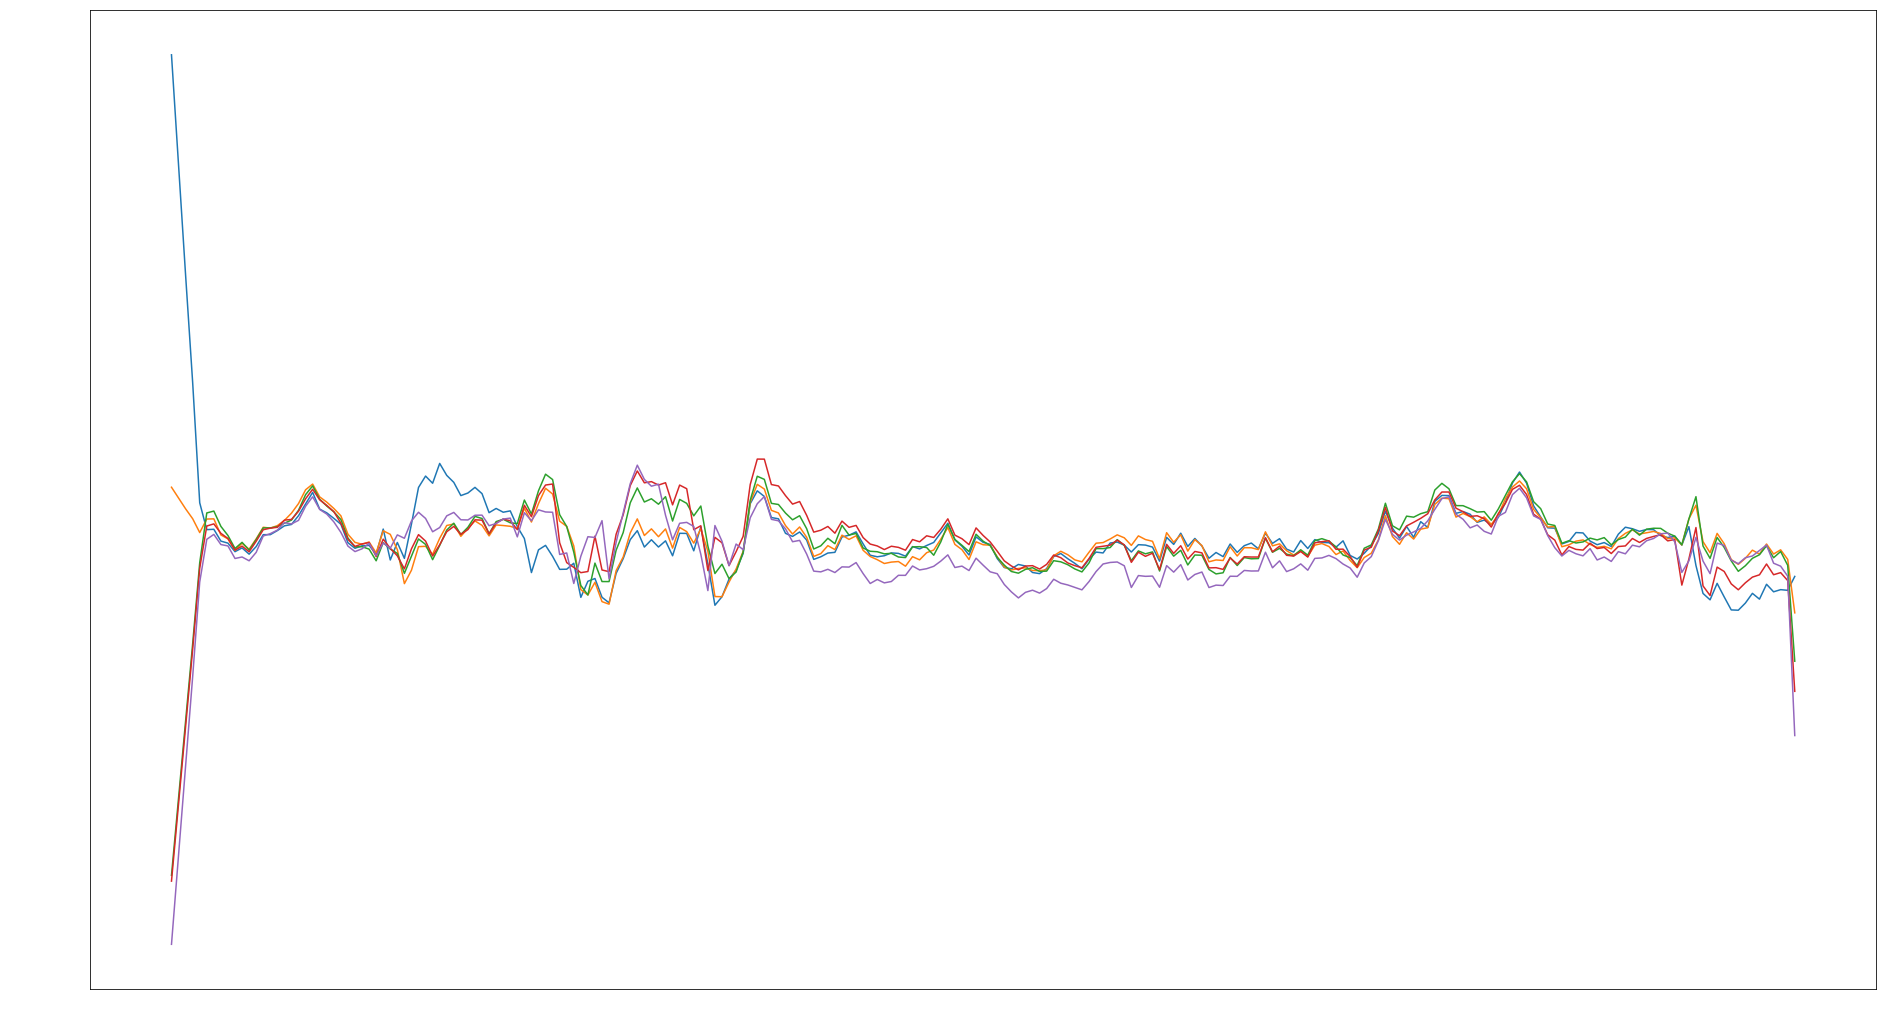

In [7]:
PROJECT_ROOT_DIR = "."
def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

wp_list = []
for i in range(5):
    wp = pywt.WaveletPacket(y[:, i], wavelet='db4', mode='smooth')
    wp_list.append(wp['aaa'].data)

for i in wp_list:
    plt.plot(i)
plt.show


# CNN

## Preprocessing

In [8]:
import pyedflib
import os
import numpy as np
%matplotlib inline

MAX_SAMPLE = 19680
NUM_OF_CHANNEL = 5
X = np.array([])
counter = 0
all_dirs = sorted(os.listdir('MI'))
exclude = ["R01", "R02", "R03", "R05", "R07", "R09", "R11", "R13", "R15"]
    
CURRENT_DIR = os.getcwd()
for dirs in all_dirs:
    for j in sorted(os.listdir(os.path.join('MI', dirs))):
        path = os.path.join(CURRENT_DIR , 'MI', dirs, j)
        if j[4:7] not in exclude:
            with pyedflib.EdfReader(path) as f:
                n = f.signals_in_file
                signal_labels = f.getSignalLabels()
                sigbufs = np.zeros((MAX_SAMPLE, NUM_OF_CHANNEL))
                for i in np.arange(NUM_OF_CHANNEL):
                    sigbufs[:, i] = f.readSignal(i+7)[:MAX_SAMPLE]
                X = np.append(X, sigbufs)
            counter += 1
            if counter >= 6*56:
                break
    if counter >= 6*56:
        break
%time

CPU times: user 11 µs, sys: 3 µs, total: 14 µs
Wall time: 9.06 µs


In [9]:
X = np.array(X)
X = X.reshape(336, -1, 5)
print(f'X shape is {X.shape}')

X shape is (336, 19680, 5)


### Wavelets Packet Decomposition

In [10]:
import pywt

x_train = np.array([])
for it in X:  # 336
    for num in range(5):
        res = pywt.WaveletPacket(it[:, num], wavelet='db4', mode='smooth')['aaa'].data
        x_train = np.append(x_train, res)

In [11]:
x_train = x_train.reshape(336, -1, 5)
print(f'x_train shape is {x_train.shape}')

x_train shape is (336, 2466, 5)


After wavelets shape = (2466, 5)


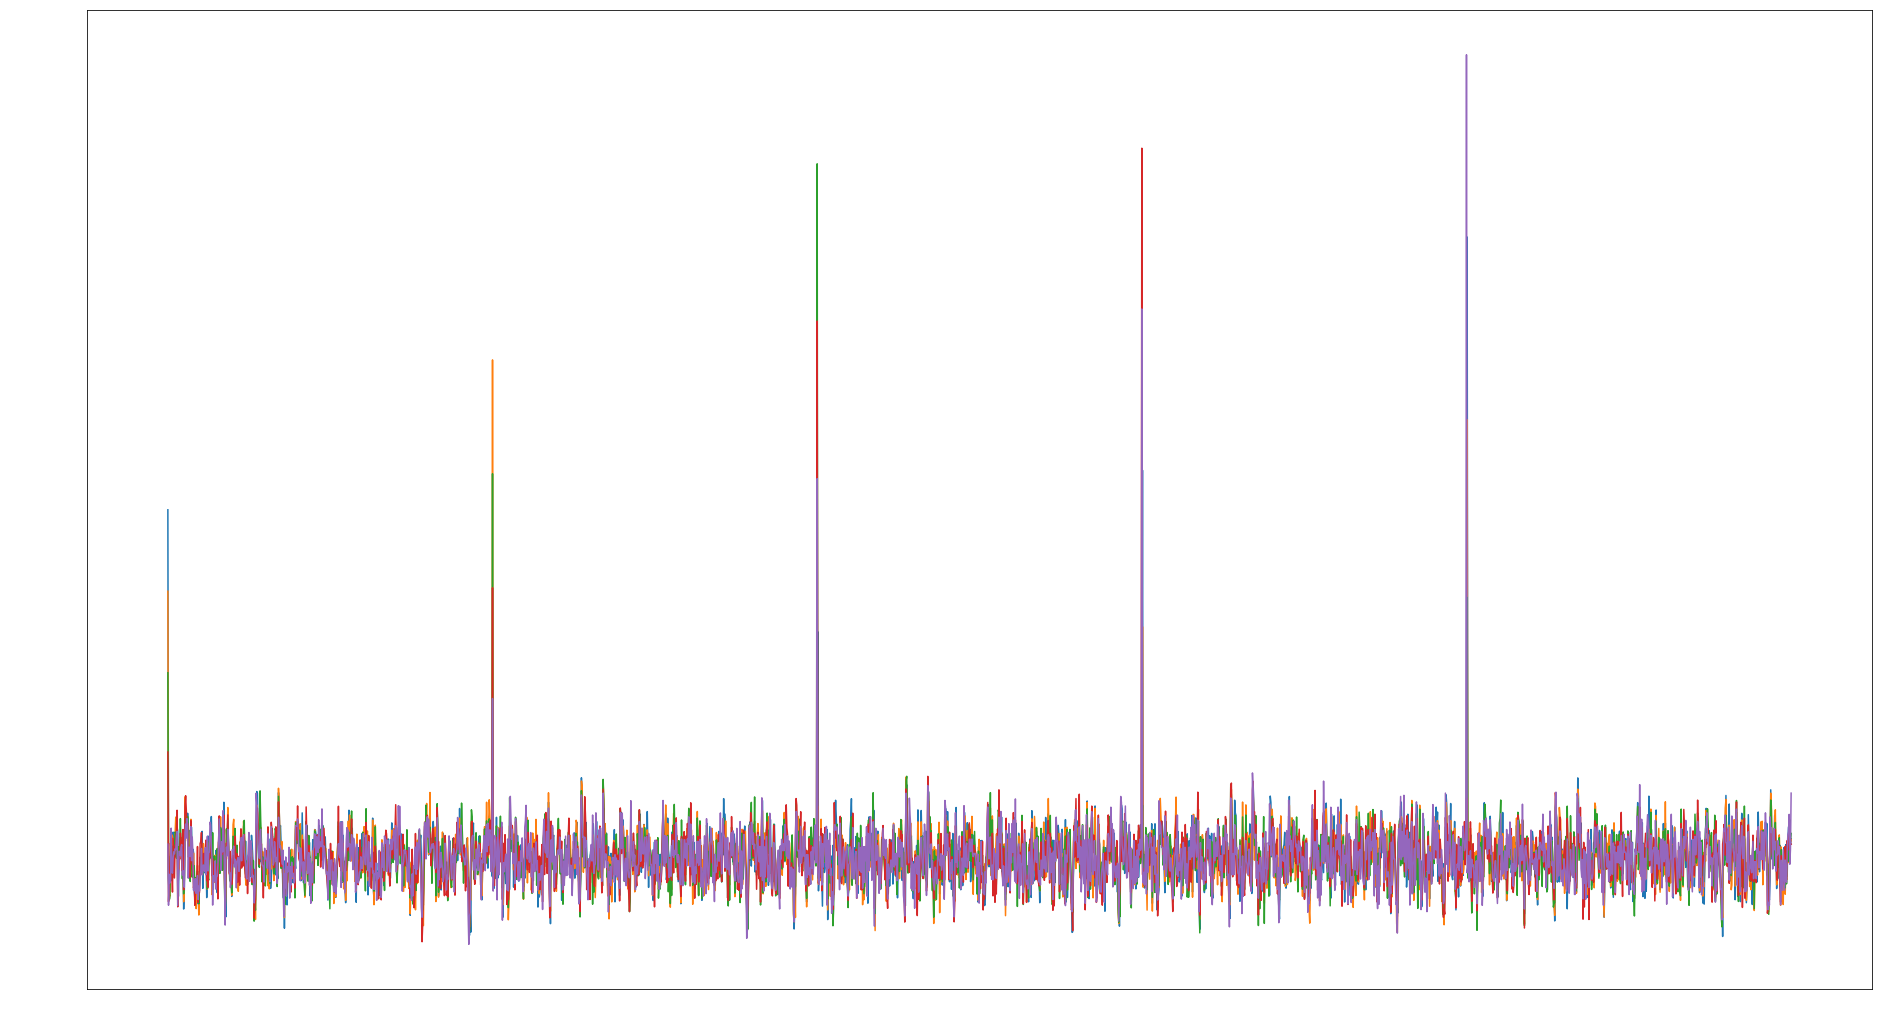

In [12]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 26}
plt.rc('font', **font)
plt.rcParams["figure.figsize"] = [32,18]

plt.rcParams.update({'text.color' : "teal",
                     'axes.labelcolor' : "white",
                     'xtick.color' : "white",
                     'ytick.color' : "white"})
print(f"After wavelets shape = {x_train[0].shape}")
x_train 
plt.plot(x_train[0])

## Tensorflow

### Hyperparameters

In [13]:
import tensorflow as tf

N_OUTPUTS = 1
BATCH_SIZE = 24
INPUT_HEIGHT  = 1
INPUT_WIDTH = x_train.shape[1]
NUM_LABELS = 1    # yes or no
NUM_CHANNELS = 6  # C5 C3 C1 CZ C2 C4
KERNEL_SIZE = 60
DEPTH = 1
NUM_HIDDEN = 1000
LR = 0.0001
TOTAL = 6*56
EPOCHS = 56

/home/chrislu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Construct the graph

In [14]:
graph = tf.Graph()

with graph.as_default():
    input_data = tf.placeholder(tf.float32, [None, INPUT_WIDTH, NUM_CHANNELS], name='inputs')
    labels = tf.placeholder(tf.float32, [None, NUM_LABELS], name='labels')
    prob = tf.placeholder(tf.float32, name='prob')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

In [15]:
with graph.as_default():
    # 1st layer (batch, 1200, 6) -> (batch, 600, 12)
    conv1 = tf.layers.conv1d(
            inputs=input_data, 
            filters=12,
            kernel_size=2,
            strides=1,
            padding='same',
            activation=tf.nn.relu)
    max_pool_1 = tf.layers.max_pooling1d(
            inputs=conv1,
            pool_size=2,
            strides=2,
            padding='same')
    
    # 2nd layer (batch, 600, 12) -> (batch, 300, 24)
    conv2 = tf.layers.conv1d(
            inputs=max_pool_1, 
            filters=24,
            kernel_size=2,
            strides=1,
            padding='same',
            activation=tf.nn.relu)
    max_pool_2 = tf.layers.max_pooling1d(
            inputs=conv2,
            pool_size=2,
            strides=2,
            padding='same')
    
    # 3rd layer (batch, 300, 24) -> (batch, 150, 48)
    conv3 = tf.layers.conv1d(
            inputs=max_pool_2, 
            filters=48,
            kernel_size=2,
            strides=1,
            padding='same',
            activation=tf.nn.relu)
    max_pool_3 = tf.layers.max_pooling1d(
            inputs=conv3,
            pool_size=2,
            strides=2,
            padding='same')
    
     # 4 layer (batch, 150, 48) -> (batch, 75, 96)
    conv4 = tf.layers.conv1d(
            inputs=max_pool_3, 
            filters=96,
            kernel_size=2,
            strides=1,
            padding='same',
            activation=tf.nn.relu)
    max_pool_4 = tf.layers.max_pooling1d(
            inputs=conv4,
            pool_size=2,
            strides=2,
            padding='same')

In [16]:
with graph.as_default():
    # Flatten and add dropout
    flat = tf.reshape(max_pool_4, (-1, 75*96))
    flat = tf.nn.dropout(flat, keep_prob=prob)
    
    # Predictions
    logits = tf.layers.dense(flat, NUM_LABELS)
    
    # Cost function and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    
    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



### Start Training

In [17]:
if (os.path.exists('checkpoints-cnn') == False):
    !mkdir checkpoints-cnn

In [18]:
#validation_acc = []
#validation_loss = []

train_acc = []
train_loss = []

with graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    writer = tf.summary.FileWriter('./graphs', sess.graph)
    iteration = 0
   # Loop over epochs
    for e in range(EPOCHS):
            
        # Feed dictionary
        x = np.array(x_train[iteration*14:iteration*14+14])
        y = np.ones((14,1))
        feed = {input_data : x, labels : y, prob : 0.5, learning_rate : LR}
            
        # Loss
        loss, _ , acc = sess.run([cost, optimizer, accuracy], feed_dict = feed)
        train_acc.append(acc)
        train_loss.append(loss)
            
        # Print at each 5 iters
        if (iteration % 2 == 0):
            print("Epoch: {}/{}".format(e, EPOCHS),
                  "Iteration: {:d}".format(iteration),
                  "Train loss: {:6f}".format(loss),
                  "Train acc: {:.6f}".format(acc))
            
        # Compute validation loss at every 10 iterations
        #if (iteration%10 == 0):                
#             val_acc_ = []
#             val_loss_ = []
                
#             for x_v, y_v in get_batches(X_vld, y_vld, batch_size):
#                  # Feed
#                 feed = {inputs_ : x_v, labels_ : y_v, keep_prob_ : 1.0}  
                    
#                 # Loss
#                 loss_v, acc_v = sess.run([cost, accuracy], feed_dict = feed)                    
#                 val_acc_.append(acc_v)
#                 val_loss_.append(loss_v)
                
#                 # Print info
#             print("Epoch: {}/{}".format(e, epochs),
#                   "Iteration: {:d}".format(iteration),
#                   "Validation loss: {:6f}".format(np.mean(val_loss_)),
#                   "Validation acc: {:.6f}".format(np.mean(val_acc_)))
                
#             # Store
#             validation_acc.append(np.mean(val_acc_))
#             validation_loss.append(np.mean(val_loss_))
            
        # Iterate 
        iteration += 1

    saver.save(sess,"checkpoints-cnn/har.ckpt")
%time

ValueError: Cannot feed value of shape (14, 2466, 5) for Tensor 'inputs:0', which has shape '(?, 2466, 6)'

## Pytorch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
class EEGHandler(nn.Module):
    def __init__(self):
        super(self).__init()
        self.T = 120
        
        # Layer 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(1, 64), padding=0)
        self.batchnorm1 = nn.BatchNorm2d(16, False)
        
        # Layer 2
        self.padding1 = nn.ZeroPad2d((16, 17, 0, 1))
        self.conv2 = nn.Conv2d(1, 4, (2, 32))
        self.batchnorm2 = nn.BatchNorm2d(4, False)
        self.pooling2 = nn.MaxPool2d(2, 4)
        
        # Layer 3
        self.padding2 = nn.ZeroPad2d((2, 1, 4, 3))
        self.conv3 = nn.Conv2d(4, 4, (8, 4))
        self.batchnorm3 = nn.BatchNorm2d(4, False)
        self.pooling3 = nn.MaxPool2d((2, 4))
        
        # FC Layer
        # NOTE: This dimension will depend on the number of timestamps per sample in your data.
        # I have 120 timepoints. 
        self.fc1 = nn.Linear(4*2*7, 1)
        

    def forward(self, x):
        # Layer 1
        x = F.elu(self.conv1(x))
        x = self.batchnorm1(x)
        x = F.dropout(x, 0.25)
        x = x.permute(0, 3, 1, 2)
        
        # Layer 2
        x = self.padding1(x)
        x = F.elu(self.conv2(x))
        x = self.batchnorm2(x)
        x = F.dropout(x, 0.25)
        x = self.pooling2(x)
        
        # Layer 3
        x = self.padding2(x)
        x = F.elu(self.conv3(x))
        x = self.batchnorm3(x)
        x = F.dropout(x, 0.25)
        x = self.pooling3(x)
        
        # FC Layer
        x = x.view(-1, 4*2*7)
        x = F.sigmoid(self.fc1(x))
        return x

In [ ]:
net = EEGHandler().cuda(0)
print(net.forward(Variable(torch.Tensor(np.random.rand(1, 1, 120, 64)).cuda(0))))
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters())